### This is the tutorial of deep learning on FashionMNIST dataset using Pytorch. We will build a Convolutional Neural Network for predicting the classes of Dataset. I am assuming you know the basics of deep leanrning like layer architecture... convolution concepts. Without further ado... Lets start the tutorial.

# **Importing Important Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from torch import autocast
from tqdm import tqdm

import time

### If the GPU is available use it for the computation otherwise use the CPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

There are 2 ways to load the Fashion MNIST dataset. 


    1.   Load csv and then inherite Pytorch Dataset class .
    2.   Use Pytorch module torchvision.datasets. It has many popular datasets like MNIST, FashionMNIST, CIFAR10 e.t.c.
    
    

*   We use DataLoader class from torch.utils.data to load data in batches  in both method.
* Comment out the code of a method which you are not using. 






### 2. Using FashionMNIST class from torchvision module.


*   It will download the dataset first time.




In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

100%|██████████| 26421880/26421880 [00:03<00:00, 8521075.17it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 143059.57it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2712571.28it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1440829.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=200)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=200)


### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.





In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([200, 1, 28, 28])

In [ ]:
len(train_set)

60000

9


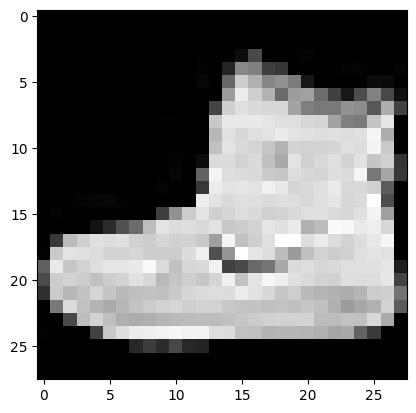

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

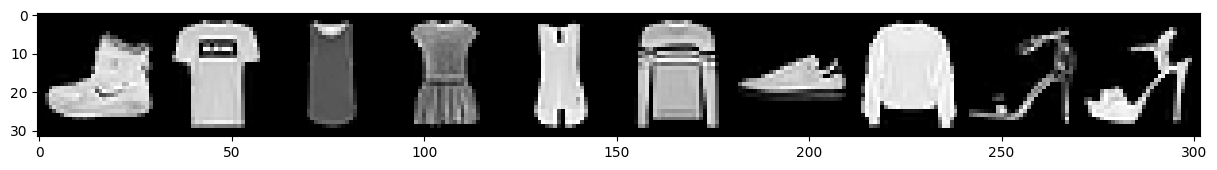

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")


## Building a CNN 


*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

> Lets implementing the network...





In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



In [ ]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                  [-1, 120]          72,120
           Linear-12                   [-1, 10]           1,210
Total params: 1,475,338
Trainable params: 1,475,338
Non-trainable params: 0
---------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


## Training a network and Testing it on test dataset

In [ ]:
for images, labels in train_loader:
    print(labels)
    break

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7,
        5, 5, 9, 2, 2, 2, 7, 6, 4, 1, 8, 7, 7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1,
        8, 7, 1, 2, 8, 0, 9, 1, 8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9,
        6, 0, 1, 0, 5, 5, 1, 7, 0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0,
        5, 8, 4, 1, 1, 2, 9, 2])


In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    print('Current Epoch:',epoch)

    for images, labels in tqdm(train_loader):
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = images
        labels = labels
        
        start = time.time()
        # Forward pass

        outputs = model(train)
        loss = error(outputs, labels)

        # with autocast(device_type='cuda', dtype=torch.float16): 
        #     outputs = model(train)
        #     loss = error(outputs, labels)

        stop = time.time()

        print("time for batch: ", stop-start)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad(set_to_none=True)
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = images
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data.detach().cpu().numpy())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Current Epoch: 0


  0%|          | 0/300 [00:00<?, ?it/s]

time for batch:  0.01594066619873047


  2%|▏         | 5/300 [00:00<00:37,  7.77it/s]

time for batch:  0.0014662742614746094
time for batch:  0.00107574462890625
time for batch:  0.0010733604431152344
time for batch:  0.0013632774353027344
time for batch:  0.0010802745819091797
time for batch:  0.0010547637939453125
time for batch:  0.0009932518005371094


  4%|▍         | 13/300 [00:01<00:15, 18.54it/s]

time for batch:  0.003883838653564453
time for batch:  0.00103759765625
time for batch:  0.0010366439819335938
time for batch:  0.001026153564453125
time for batch:  0.001026153564453125
time for batch:  0.0009865760803222656
time for batch:  0.0009729862213134766
time for batch:  0.001054525375366211


  7%|▋         | 21/300 [00:01<00:10, 25.66it/s]

time for batch:  0.0010917186737060547
time for batch:  0.0010519027709960938
time for batch:  0.0010874271392822266
time for batch:  0.000993967056274414
time for batch:  0.0009601116180419922
time for batch:  0.0010418891906738281
time for batch:  0.00099945068359375
time for batch:  0.0009589195251464844


 10%|▉         | 29/300 [00:01<00:08, 30.17it/s]

time for batch:  0.0009922981262207031
time for batch:  0.0010852813720703125
time for batch:  0.0011188983917236328
time for batch:  0.001043081283569336
time for batch:  0.0009739398956298828
time for batch:  0.0009753704071044922
time for batch:  0.0009381771087646484


 12%|█▏        | 37/300 [00:01<00:08, 32.61it/s]

time for batch:  0.000989675521850586
time for batch:  0.0009808540344238281
time for batch:  0.0009834766387939453
time for batch:  0.0009796619415283203
time for batch:  0.0014758110046386719
time for batch:  0.001024484634399414
time for batch:  0.0009553432464599609
time for batch:  0.0009527206420898438


 15%|█▌        | 45/300 [00:01<00:07, 34.40it/s]

time for batch:  0.0009889602661132812
time for batch:  0.001010894775390625
time for batch:  0.0010020732879638672
time for batch:  0.0009658336639404297
time for batch:  0.0009481906890869141
time for batch:  0.0010068416595458984
time for batch:  0.0010831356048583984
time for batch:  0.0009675025939941406


 16%|█▋        | 49/300 [00:02<00:07, 34.56it/s]

time for batch:  0.0009484291076660156
time for batch:  0.0009658336639404297
time for batch:  0.0011148452758789062


 19%|█▉        | 57/300 [00:03<00:24,  9.89it/s]

time for batch:  0.0010020732879638672
time for batch:  0.0008673667907714844
time for batch:  0.0008628368377685547
time for batch:  0.0008749961853027344
time for batch:  0.0008318424224853516
time for batch:  0.0009772777557373047
time for batch:  0.0011222362518310547


 22%|██▏       | 65/300 [00:03<00:15, 15.63it/s]

time for batch:  0.0014853477478027344
time for batch:  0.0008921623229980469
time for batch:  0.0009002685546875
time for batch:  0.0008375644683837891
time for batch:  0.0008969306945800781
time for batch:  0.0009071826934814453
time for batch:  0.0008573532104492188
time for batch:  0.0009324550628662109


 24%|██▍       | 73/300 [00:04<00:10, 21.85it/s]

time for batch:  0.0009374618530273438
time for batch:  0.0009074211120605469
time for batch:  0.0008680820465087891
time for batch:  0.0008845329284667969
time for batch:  0.0008633136749267578
time for batch:  0.0008931159973144531
time for batch:  0.0008780956268310547
time for batch:  0.0009777545928955078


 27%|██▋       | 81/300 [00:04<00:07, 27.43it/s]

time for batch:  0.0009822845458984375
time for batch:  0.0009338855743408203
time for batch:  0.000858306884765625
time for batch:  0.0008547306060791016
time for batch:  0.0008909702301025391
time for batch:  0.00089263916015625
time for batch:  0.0009162425994873047
time for batch:  0.0008814334869384766


 30%|██▉       | 89/300 [00:04<00:06, 31.14it/s]

time for batch:  0.0009551048278808594
time for batch:  0.0009219646453857422
time for batch:  0.0008666515350341797
time for batch:  0.0008366107940673828
time for batch:  0.0008711814880371094
time for batch:  0.0008323192596435547
time for batch:  0.0009114742279052734
time for batch:  0.0008885860443115234


 32%|███▏      | 97/300 [00:04<00:06, 33.03it/s]

time for batch:  0.0008935928344726562
time for batch:  0.0008826255798339844
time for batch:  0.0008502006530761719
time for batch:  0.0009493827819824219
time for batch:  0.0009362697601318359
time for batch:  0.0009591579437255859
time for batch:  0.0008790493011474609
time for batch:  0.0008287429809570312
time for batch:  0.001127004623413086
time for batch:  0.0009396076202392578
time for batch:  0.0008716583251953125


 35%|███▌      | 105/300 [00:06<00:18, 10.64it/s]

time for batch:  0.00101470947265625
time for batch:  0.0010366439819335938
time for batch:  0.0008878707885742188
time for batch:  0.000873565673828125
time for batch:  0.0009753704071044922
time for batch:  0.0009791851043701172
time for batch:  0.000957489013671875


 38%|███▊      | 113/300 [00:06<00:11, 16.53it/s]

time for batch:  0.0009450912475585938
time for batch:  0.0008943080902099609
time for batch:  0.0008902549743652344
time for batch:  0.000843048095703125
time for batch:  0.0009062290191650391
time for batch:  0.0008900165557861328
time for batch:  0.0009188652038574219
time for batch:  0.0009086132049560547


 40%|████      | 121/300 [00:06<00:07, 22.66it/s]

time for batch:  0.0010139942169189453
time for batch:  0.0009431838989257812
time for batch:  0.0009927749633789062
time for batch:  0.0009500980377197266
time for batch:  0.0009136199951171875
time for batch:  0.0009350776672363281
time for batch:  0.000896453857421875
time for batch:  0.0009799003601074219


 43%|████▎     | 129/300 [00:06<00:06, 27.50it/s]

time for batch:  0.001073598861694336
time for batch:  0.0010097026824951172
time for batch:  0.0009734630584716797
time for batch:  0.001008749008178711
time for batch:  0.000904083251953125
time for batch:  0.0011200904846191406
time for batch:  0.0015635490417480469


 44%|████▍     | 133/300 [00:07<00:06, 24.47it/s]

time for batch:  0.0016367435455322266
time for batch:  0.0014634132385253906
time for batch:  0.0017871856689453125
time for batch:  0.0012276172637939453
time for batch:  0.0009570121765136719


 46%|████▋     | 139/300 [00:07<00:06, 25.03it/s]

time for batch:  0.0011763572692871094
time for batch:  0.0011701583862304688
time for batch:  0.0011167526245117188
time for batch:  0.0010731220245361328
time for batch:  0.0010638236999511719
time for batch:  0.0010502338409423828


 48%|████▊     | 145/300 [00:07<00:06, 25.25it/s]

time for batch:  0.0011091232299804688
time for batch:  0.001279592514038086
time for batch:  0.0011129379272460938
time for batch:  0.001088857650756836
time for batch:  0.0012464523315429688
time for batch:  0.001127481460571289


 49%|████▉     | 148/300 [00:07<00:05, 25.47it/s]

time for batch:  0.001115560531616211
time for batch:  0.001186370849609375
time for batch:  0.0010724067687988281


 52%|█████▏    | 155/300 [00:09<00:17,  8.22it/s]

time for batch:  0.0009076595306396484
time for batch:  0.0009145736694335938
time for batch:  0.0009083747863769531
time for batch:  0.0009307861328125
time for batch:  0.0008337497711181641
time for batch:  0.0009601116180419922
time for batch:  0.0008797645568847656
time for batch:  0.0008130073547363281


 54%|█████▍    | 163/300 [00:09<00:09, 14.41it/s]

time for batch:  0.0008673667907714844
time for batch:  0.0008749961853027344
time for batch:  0.0008399486541748047
time for batch:  0.0008172988891601562
time for batch:  0.0008215904235839844
time for batch:  0.0008652210235595703
time for batch:  0.0008230209350585938
time for batch:  0.0010898113250732422


 57%|█████▋    | 171/300 [00:09<00:06, 21.42it/s]

time for batch:  0.00083160400390625
time for batch:  0.0008137226104736328
time for batch:  0.0010867118835449219
time for batch:  0.0008313655853271484
time for batch:  0.0008680820465087891
time for batch:  0.0008492469787597656
time for batch:  0.0008368492126464844
time for batch:  0.0008366107940673828


 60%|█████▉    | 179/300 [00:10<00:04, 26.75it/s]

time for batch:  0.0009474754333496094
time for batch:  0.0008842945098876953
time for batch:  0.0009055137634277344
time for batch:  0.0013017654418945312
time for batch:  0.0009539127349853516
time for batch:  0.0008761882781982422
time for batch:  0.0008344650268554688
time for batch:  0.0008921623229980469


 62%|██████▏   | 187/300 [00:10<00:03, 31.00it/s]

time for batch:  0.00090789794921875
time for batch:  0.0009505748748779297
time for batch:  0.0010166168212890625
time for batch:  0.0008807182312011719
time for batch:  0.0008745193481445312
time for batch:  0.0009551048278808594
time for batch:  0.0008528232574462891
time for batch:  0.0008282661437988281


 65%|██████▌   | 195/300 [00:10<00:03, 34.08it/s]

time for batch:  0.0008563995361328125
time for batch:  0.0008599758148193359
time for batch:  0.0008592605590820312
time for batch:  0.0008838176727294922
time for batch:  0.0008370876312255859
time for batch:  0.0010342597961425781
time for batch:  0.0009343624114990234
time for batch:  0.0008985996246337891


 66%|██████▋   | 199/300 [00:10<00:02, 34.20it/s]

time for batch:  0.0009543895721435547
time for batch:  0.0009164810180664062


 69%|██████▊   | 206/300 [00:11<00:09, 10.10it/s]

time for batch:  0.0010097026824951172
time for batch:  0.0008728504180908203
time for batch:  0.0011065006256103516
time for batch:  0.0010693073272705078
time for batch:  0.0009818077087402344
time for batch:  0.0009188652038574219
time for batch:  0.0009186267852783203


 71%|███████▏  | 214/300 [00:12<00:05, 16.29it/s]

time for batch:  0.0009253025054931641
time for batch:  0.0008754730224609375
time for batch:  0.0008921623229980469
time for batch:  0.0009500980377197266
time for batch:  0.0009248256683349609
time for batch:  0.0009350776672363281
time for batch:  0.0009398460388183594
time for batch:  0.00102996826171875


 74%|███████▍  | 222/300 [00:12<00:03, 22.94it/s]

time for batch:  0.0009500980377197266
time for batch:  0.00095367431640625
time for batch:  0.0008902549743652344
time for batch:  0.0008912086486816406
time for batch:  0.0008733272552490234
time for batch:  0.0008594989776611328
time for batch:  0.0008797645568847656
time for batch:  0.0008797645568847656


 77%|███████▋  | 230/300 [00:12<00:02, 28.67it/s]

time for batch:  0.0008435249328613281
time for batch:  0.0008480548858642578
time for batch:  0.0008974075317382812
time for batch:  0.0008609294891357422
time for batch:  0.0008172988891601562
time for batch:  0.0008451938629150391
time for batch:  0.0009407997131347656
time for batch:  0.0008976459503173828


 79%|███████▉  | 238/300 [00:12<00:01, 32.38it/s]

time for batch:  0.0009679794311523438
time for batch:  0.0008995532989501953
time for batch:  0.0009768009185791016
time for batch:  0.0009458065032958984
time for batch:  0.0008914470672607422
time for batch:  0.0008816719055175781
time for batch:  0.0008525848388671875
time for batch:  0.0008950233459472656


 82%|████████▏ | 246/300 [00:13<00:01, 33.82it/s]

time for batch:  0.0008723735809326172
time for batch:  0.0010838508605957031
time for batch:  0.0008740425109863281
time for batch:  0.0009107589721679688
time for batch:  0.0008499622344970703
time for batch:  0.0008656978607177734
time for batch:  0.0008289813995361328
time for batch:  0.0009720325469970703
time for batch:  0.0010366439819335938
time for batch:  0.0008947849273681641
time for batch:  0.0009107589721679688


 86%|████████▌ | 258/300 [00:14<00:03, 13.90it/s]

time for batch:  0.0009334087371826172
time for batch:  0.0008594989776611328
time for batch:  0.0008447170257568359
time for batch:  0.0008428096771240234
time for batch:  0.0008826255798339844
time for batch:  0.0008485317230224609
time for batch:  0.0008697509765625
time for batch:  0.00083160400390625


 89%|████████▊ | 266/300 [00:14<00:01, 20.29it/s]

time for batch:  0.0008537769317626953
time for batch:  0.0008654594421386719
time for batch:  0.0009644031524658203
time for batch:  0.0009493827819824219
time for batch:  0.0009534358978271484
time for batch:  0.0008924007415771484
time for batch:  0.0010135173797607422
time for batch:  0.0008761882781982422


 91%|█████████▏| 274/300 [00:15<00:01, 25.95it/s]

time for batch:  0.0008707046508789062
time for batch:  0.0008862018585205078
time for batch:  0.0008797645568847656
time for batch:  0.0008499622344970703
time for batch:  0.0010161399841308594
time for batch:  0.0008733272552490234
time for batch:  0.0008530616760253906
time for batch:  0.0008656978607177734


 94%|█████████▍| 282/300 [00:15<00:00, 30.18it/s]

time for batch:  0.0008697509765625
time for batch:  0.0010132789611816406
time for batch:  0.001453399658203125
time for batch:  0.0009403228759765625
time for batch:  0.0010051727294921875
time for batch:  0.0009033679962158203
time for batch:  0.0009446144104003906
time for batch:  0.0008616447448730469


 97%|█████████▋| 290/300 [00:15<00:00, 32.55it/s]

time for batch:  0.0012848377227783203
time for batch:  0.0009763240814208984
time for batch:  0.0010101795196533203
time for batch:  0.0009644031524658203
time for batch:  0.0009658336639404297
time for batch:  0.0009245872497558594
time for batch:  0.0009963512420654297
time for batch:  0.0009067058563232422


 99%|█████████▉| 298/300 [00:15<00:00, 34.50it/s]

time for batch:  0.0009765625
time for batch:  0.0008816719055175781
time for batch:  0.0008871555328369141
time for batch:  0.0008494853973388672
time for batch:  0.0009145736694335938
time for batch:  0.000988006591796875
time for batch:  0.0008625984191894531
time for batch:  0.0008573532104492188
time for batch:  0.0008804798126220703
time for batch:  0.0008914470672607422


100%|██████████| 300/300 [00:17<00:00, 17.61it/s]


Current Epoch: 1


  1%|▏         | 4/300 [00:00<00:08, 35.99it/s]

time for batch:  0.0009706020355224609
time for batch:  0.0008480548858642578
time for batch:  0.0009407997131347656
time for batch:  0.0009100437164306641
time for batch:  0.0009822845458984375
time for batch:  0.0009016990661621094
time for batch:  0.0009250640869140625


  3%|▎         | 8/300 [00:00<00:08, 34.95it/s]

time for batch:  0.0009419918060302734


  4%|▍         | 12/300 [00:00<00:08, 35.87it/s]

time for batch:  0.0009055137634277344
time for batch:  0.0008804798126220703
time for batch:  0.0008301734924316406
time for batch:  0.0008680820465087891
time for batch:  0.0009021759033203125
time for batch:  0.0008237361907958984
time for batch:  0.0008640289306640625


  5%|▌         | 16/300 [00:00<00:07, 35.98it/s]

time for batch:  0.0008947849273681641


  7%|▋         | 20/300 [00:00<00:07, 36.25it/s]

time for batch:  0.0010385513305664062
time for batch:  0.0009150505065917969
time for batch:  0.000873565673828125
time for batch:  0.0008578300476074219
time for batch:  0.0009045600891113281
time for batch:  0.0009105205535888672
time for batch:  0.0008246898651123047


  8%|▊         | 24/300 [00:00<00:07, 35.95it/s]

time for batch:  0.0009007453918457031


  9%|▉         | 28/300 [00:00<00:07, 35.69it/s]

time for batch:  0.0008611679077148438
time for batch:  0.0010607242584228516
time for batch:  0.0010902881622314453
time for batch:  0.0008878707885742188
time for batch:  0.0009219646453857422
time for batch:  0.0008630752563476562
time for batch:  0.0009021759033203125


 11%|█         | 32/300 [00:00<00:07, 36.08it/s]

time for batch:  0.00084686279296875


 12%|█▏        | 36/300 [00:01<00:07, 35.60it/s]

time for batch:  0.0008485317230224609
time for batch:  0.0008268356323242188
time for batch:  0.0008184909820556641
time for batch:  0.000865936279296875
time for batch:  0.0009014606475830078
time for batch:  0.0008261203765869141
time for batch:  0.0009505748748779297


 13%|█▎        | 40/300 [00:01<00:07, 35.56it/s]

time for batch:  0.0009660720825195312


 15%|█▍        | 44/300 [00:01<00:07, 35.80it/s]

time for batch:  0.0009281635284423828
time for batch:  0.0008614063262939453
time for batch:  0.0008726119995117188
time for batch:  0.0008471012115478516
time for batch:  0.0013630390167236328
time for batch:  0.0011970996856689453


 16%|█▌        | 48/300 [00:01<00:08, 30.61it/s]

time for batch:  0.0016705989837646484
time for batch:  0.0016222000122070312
time for batch:  0.0012829303741455078
time for batch:  0.0012891292572021484


 19%|█▊        | 56/300 [00:03<00:27,  8.76it/s]

time for batch:  0.0009698867797851562
time for batch:  0.0009202957153320312
time for batch:  0.0008561611175537109
time for batch:  0.0008320808410644531
time for batch:  0.0008537769317626953
time for batch:  0.0008857250213623047
time for batch:  0.0008356571197509766
time for batch:  0.0008285045623779297


 21%|██▏       | 64/300 [00:03<00:16, 14.28it/s]

time for batch:  0.0009124279022216797
time for batch:  0.0008492469787597656
time for batch:  0.0011146068572998047
time for batch:  0.0009806156158447266
time for batch:  0.0011227130889892578
time for batch:  0.00095367431640625
time for batch:  0.0010895729064941406
time for batch:  0.0008847713470458984


 24%|██▍       | 72/300 [00:03<00:10, 20.73it/s]

time for batch:  0.0008749961853027344
time for batch:  0.0008788108825683594
time for batch:  0.0008759498596191406
time for batch:  0.0008678436279296875
time for batch:  0.0008308887481689453
time for batch:  0.0008382797241210938
time for batch:  0.0008337497711181641
time for batch:  0.0008347034454345703


 27%|██▋       | 80/300 [00:03<00:08, 26.77it/s]

time for batch:  0.0008456707000732422
time for batch:  0.0008203983306884766
time for batch:  0.0008499622344970703
time for batch:  0.0008227825164794922
time for batch:  0.0008347034454345703
time for batch:  0.0008230209350585938
time for batch:  0.0008342266082763672
time for batch:  0.0009233951568603516


 29%|██▉       | 88/300 [00:04<00:07, 29.82it/s]

time for batch:  0.0008840560913085938
time for batch:  0.0008335113525390625
time for batch:  0.0010678768157958984
time for batch:  0.0008292198181152344
time for batch:  0.0009810924530029297
time for batch:  0.0009121894836425781
time for batch:  0.0009150505065917969


 32%|███▏      | 96/300 [00:04<00:06, 32.45it/s]

time for batch:  0.0008676052093505859
time for batch:  0.0009086132049560547
time for batch:  0.0011370182037353516
time for batch:  0.0009429454803466797
time for batch:  0.0008702278137207031
time for batch:  0.0008783340454101562
time for batch:  0.0009205341339111328
time for batch:  0.0008938312530517578
time for batch:  0.001010894775390625
time for batch:  0.0008366107940673828
time for batch:  0.000850677490234375


 36%|███▌      | 108/300 [00:05<00:14, 13.19it/s]

time for batch:  0.0009686946868896484
time for batch:  0.0008902549743652344
time for batch:  0.0008757114410400391
time for batch:  0.0009284019470214844
time for batch:  0.0008785724639892578
time for batch:  0.0009047985076904297
time for batch:  0.0009202957153320312
time for batch:  0.0008344650268554688


 37%|███▋      | 112/300 [00:06<00:11, 16.20it/s]

time for batch:  0.0008716583251953125
time for batch:  0.0008363723754882812
time for batch:  0.0010013580322265625
time for batch:  0.0008471012115478516
time for batch:  0.0013575553894042969
time for batch:  0.0009069442749023438
time for batch:  0.0012202262878417969
time for batch:  0.0008327960968017578


 41%|████▏     | 124/300 [00:06<00:06, 25.55it/s]

time for batch:  0.0008306503295898438
time for batch:  0.0009799003601074219
time for batch:  0.0008516311645507812
time for batch:  0.0008480548858642578
time for batch:  0.0008437633514404297
time for batch:  0.0008647441864013672
time for batch:  0.000904083251953125
time for batch:  0.0008018016815185547


 44%|████▍     | 132/300 [00:06<00:05, 30.19it/s]

time for batch:  0.0008559226989746094
time for batch:  0.0008373260498046875
time for batch:  0.0009531974792480469
time for batch:  0.0008368492126464844
time for batch:  0.0008554458618164062
time for batch:  0.0008220672607421875
time for batch:  0.0008349418640136719
time for batch:  0.0008876323699951172


 47%|████▋     | 140/300 [00:06<00:04, 32.84it/s]

time for batch:  0.0009300708770751953
time for batch:  0.0008666515350341797
time for batch:  0.0008397102355957031
time for batch:  0.0009150505065917969
time for batch:  0.0009169578552246094
time for batch:  0.0008728504180908203
time for batch:  0.0008497238159179688
time for batch:  0.0009839534759521484


 49%|████▉     | 148/300 [00:07<00:04, 34.32it/s]

time for batch:  0.0009160041809082031
time for batch:  0.0010480880737304688
time for batch:  0.0008573532104492188
time for batch:  0.0008404254913330078
time for batch:  0.0008752346038818359
time for batch:  0.0008642673492431641
time for batch:  0.0008573532104492188
time for batch:  0.0008459091186523438
time for batch:  0.0009014606475830078
time for batch:  0.0009486675262451172


 52%|█████▏    | 156/300 [00:08<00:13, 10.57it/s]

time for batch:  0.0009300708770751953
time for batch:  0.0009145736694335938
time for batch:  0.0009179115295410156
time for batch:  0.0008416175842285156
time for batch:  0.0009167194366455078
time for batch:  0.0008559226989746094
time for batch:  0.0008869171142578125
time for batch:  0.0008871555328369141


 55%|█████▍    | 164/300 [00:08<00:08, 16.57it/s]

time for batch:  0.0008366107940673828
time for batch:  0.0008358955383300781
time for batch:  0.0008764266967773438
time for batch:  0.0008459091186523438
time for batch:  0.0009236335754394531
time for batch:  0.0009148120880126953
time for batch:  0.0008492469787597656
time for batch:  0.0008575916290283203


 57%|█████▋    | 172/300 [00:08<00:05, 22.64it/s]

time for batch:  0.0008950233459472656
time for batch:  0.000982046127319336
time for batch:  0.0009009838104248047
time for batch:  0.0009224414825439453
time for batch:  0.0008554458618164062
time for batch:  0.0008444786071777344
time for batch:  0.0008842945098876953


 60%|██████    | 180/300 [00:09<00:04, 27.42it/s]

time for batch:  0.0013897418975830078
time for batch:  0.0009036064147949219
time for batch:  0.0009274482727050781
time for batch:  0.0009248256683349609
time for batch:  0.0008969306945800781
time for batch:  0.0008418560028076172
time for batch:  0.0008344650268554688


 63%|██████▎   | 188/300 [00:09<00:03, 31.58it/s]

time for batch:  0.0017237663269042969
time for batch:  0.0008528232574462891
time for batch:  0.0008182525634765625
time for batch:  0.0008795261383056641
time for batch:  0.0009052753448486328
time for batch:  0.0008299350738525391
time for batch:  0.0008997917175292969
time for batch:  0.0008511543273925781


 65%|██████▌   | 196/300 [00:09<00:03, 33.45it/s]

time for batch:  0.0009658336639404297
time for batch:  0.0008401870727539062
time for batch:  0.0008895397186279297
time for batch:  0.0008885860443115234
time for batch:  0.0009188652038574219
time for batch:  0.0009930133819580078
time for batch:  0.0011944770812988281
time for batch:  0.0008554458618164062
time for batch:  0.0008366107940673828
time for batch:  0.0008411407470703125
time for batch:  0.00080108642578125
time for batch:  0.0008709430694580078


 68%|██████▊   | 204/300 [00:11<00:09, 10.56it/s]

Iteration: 500, Loss: 0.3119489252567291, Accuracy: 88.93000030517578%
time for batch:  0.0009374618530273438
time for batch:  0.0009407997131347656
time for batch:  0.0009174346923828125
time for batch:  0.0008294582366943359
time for batch:  0.0009417533874511719
time for batch:  0.0008711814880371094


 71%|███████   | 212/300 [00:11<00:05, 16.43it/s]

time for batch:  0.0014660358428955078
time for batch:  0.0008630752563476562
time for batch:  0.0010387897491455078
time for batch:  0.000843048095703125
time for batch:  0.0008568763732910156
time for batch:  0.0008580684661865234
time for batch:  0.0008797645568847656
time for batch:  0.0008432865142822266


 73%|███████▎  | 220/300 [00:11<00:03, 22.92it/s]

time for batch:  0.0008592605590820312
time for batch:  0.0008492469787597656
time for batch:  0.0009355545043945312
time for batch:  0.0008389949798583984
time for batch:  0.0009479522705078125
time for batch:  0.0008404254913330078
time for batch:  0.0009484291076660156
time for batch:  0.0009937286376953125


 76%|███████▌  | 228/300 [00:11<00:02, 28.12it/s]

time for batch:  0.0008666515350341797
time for batch:  0.0008535385131835938
time for batch:  0.0008907318115234375
time for batch:  0.0008268356323242188
time for batch:  0.0008566379547119141
time for batch:  0.0009486675262451172
time for batch:  0.0009613037109375
time for batch:  0.0009648799896240234


 79%|███████▊  | 236/300 [00:12<00:02, 31.88it/s]

time for batch:  0.0009334087371826172
time for batch:  0.0008451938629150391
time for batch:  0.0008623600006103516
time for batch:  0.000823974609375
time for batch:  0.0008368492126464844
time for batch:  0.0010404586791992188
time for batch:  0.0008931159973144531
time for batch:  0.0009808540344238281


 81%|████████▏ | 244/300 [00:12<00:01, 33.38it/s]

time for batch:  0.0009264945983886719
time for batch:  0.0008387565612792969
time for batch:  0.0009055137634277344
time for batch:  0.0013685226440429688
time for batch:  0.0010008811950683594
time for batch:  0.0008895397186279297
time for batch:  0.0009407997131347656
time for batch:  0.0008370876312255859


 83%|████████▎ | 248/300 [00:12<00:01, 34.17it/s]

time for batch:  0.0008890628814697266
time for batch:  0.0008356571197509766
time for batch:  0.0009350776672363281
time for batch:  0.0009250640869140625


 85%|████████▌ | 255/300 [00:14<00:05,  7.82it/s]

time for batch:  0.0009284019470214844
time for batch:  0.0009207725524902344
time for batch:  0.0012085437774658203
time for batch:  0.0015273094177246094
time for batch:  0.0010075569152832031
time for batch:  0.0010027885437011719
time for batch:  0.0008916854858398438


 88%|████████▊ | 263/300 [00:14<00:02, 13.33it/s]

time for batch:  0.0009131431579589844
time for batch:  0.0009534358978271484
time for batch:  0.0009286403656005859
time for batch:  0.0009827613830566406
time for batch:  0.0008637905120849609
time for batch:  0.0008757114410400391
time for batch:  0.0008602142333984375
time for batch:  0.0008592605590820312


 90%|█████████ | 271/300 [00:14<00:01, 19.80it/s]

time for batch:  0.0008459091186523438
time for batch:  0.0009033679962158203
time for batch:  0.0009305477142333984
time for batch:  0.0008838176727294922
time for batch:  0.0008678436279296875
time for batch:  0.0009109973907470703
time for batch:  0.0010106563568115234
time for batch:  0.0009474754333496094


 93%|█████████▎| 279/300 [00:14<00:00, 25.63it/s]

time for batch:  0.0008857250213623047
time for batch:  0.0010097026824951172
time for batch:  0.0008535385131835938
time for batch:  0.0009233951568603516
time for batch:  0.0008645057678222656
time for batch:  0.0008516311645507812
time for batch:  0.0008592605590820312
time for batch:  0.0008785724639892578


 96%|█████████▌| 287/300 [00:15<00:00, 30.12it/s]

time for batch:  0.0009186267852783203
time for batch:  0.0009348392486572266
time for batch:  0.0009748935699462891
time for batch:  0.0009365081787109375
time for batch:  0.0008940696716308594
time for batch:  0.0008881092071533203
time for batch:  0.0010347366333007812
time for batch:  0.0008673667907714844


 98%|█████████▊| 295/300 [00:15<00:00, 30.74it/s]

time for batch:  0.0011677742004394531
time for batch:  0.0010247230529785156
time for batch:  0.0010972023010253906
time for batch:  0.0011141300201416016
time for batch:  0.0008747577667236328
time for batch:  0.0009169578552246094
time for batch:  0.0009200572967529297


100%|█████████▉| 299/300 [00:15<00:00, 30.79it/s]

time for batch:  0.0011031627655029297
time for batch:  0.0011599063873291016
time for batch:  0.0011942386627197266
time for batch:  0.0010962486267089844


100%|██████████| 300/300 [00:16<00:00, 17.75it/s]


Current Epoch: 2


  1%|▏         | 4/300 [00:00<00:08, 35.84it/s]

time for batch:  0.0011930465698242188
time for batch:  0.0009634494781494141
time for batch:  0.0009293556213378906
time for batch:  0.0008690357208251953
time for batch:  0.0009372234344482422
time for batch:  0.0009958744049072266


  3%|▎         | 8/300 [00:00<00:08, 34.60it/s]

time for batch:  0.0011532306671142578
time for batch:  0.0009486675262451172


  4%|▍         | 12/300 [00:00<00:08, 34.88it/s]

time for batch:  0.0009617805480957031
time for batch:  0.0009937286376953125
time for batch:  0.00102996826171875
time for batch:  0.0009067058563232422
time for batch:  0.0009553432464599609
time for batch:  0.0008909702301025391
time for batch:  0.0012576580047607422


  7%|▋         | 20/300 [00:00<00:08, 33.26it/s]

time for batch:  0.0010309219360351562
time for batch:  0.0009751319885253906
time for batch:  0.0009295940399169922
time for batch:  0.0010633468627929688
time for batch:  0.0012323856353759766


  9%|▉         | 28/300 [00:00<00:09, 28.53it/s]

time for batch:  0.002216815948486328
time for batch:  0.0009522438049316406
time for batch:  0.0009305477142333984
time for batch:  0.0008919239044189453
time for batch:  0.0009443759918212891
time for batch:  0.0009405612945556641
time for batch:  0.0008907318115234375
time for batch:  0.0008816719055175781


 12%|█▏        | 36/300 [00:01<00:08, 32.35it/s]

time for batch:  0.00095367431640625
time for batch:  0.001085519790649414
time for batch:  0.0009074211120605469
time for batch:  0.0008714199066162109
time for batch:  0.0009002685546875
time for batch:  0.0008742809295654297
time for batch:  0.0008916854858398438
time for batch:  0.0008480548858642578


 13%|█▎        | 40/300 [00:01<00:07, 32.53it/s]

time for batch:  0.0012729167938232422
time for batch:  0.0009534358978271484
time for batch:  0.0009393692016601562
time for batch:  0.0009653568267822266
time for batch:  0.0009853839874267578
time for batch:  0.000978231430053711
time for batch:  0.0009982585906982422


 16%|█▌        | 48/300 [00:01<00:07, 32.50it/s]

time for batch:  0.0012445449829101562
time for batch:  0.0010318756103515625
time for batch:  0.0010390281677246094
time for batch:  0.0008745193481445312
time for batch:  0.0008800029754638672
time for batch:  0.0009150505065917969
time for batch:  0.0008504390716552734


 19%|█▊        | 56/300 [00:02<00:23, 10.54it/s]

time for batch:  0.0009396076202392578
time for batch:  0.0009090900421142578
time for batch:  0.0010616779327392578
time for batch:  0.00091552734375
time for batch:  0.00092315673828125
time for batch:  0.0008976459503173828
time for batch:  0.0010356903076171875
time for batch:  0.0009706020355224609


 21%|██▏       | 64/300 [00:03<00:14, 16.37it/s]

time for batch:  0.0009982585906982422
time for batch:  0.0008738040924072266
time for batch:  0.0009522438049316406
time for batch:  0.0008823871612548828
time for batch:  0.0009958744049072266
time for batch:  0.0010306835174560547
time for batch:  0.0009424686431884766


 24%|██▍       | 72/300 [00:03<00:10, 22.45it/s]

time for batch:  0.0016584396362304688
time for batch:  0.0008711814880371094
time for batch:  0.0008597373962402344
time for batch:  0.0011973381042480469
time for batch:  0.0009894371032714844
time for batch:  0.0009074211120605469
time for batch:  0.0008785724639892578
time for batch:  0.0009436607360839844


 27%|██▋       | 80/300 [00:03<00:08, 27.16it/s]

time for batch:  0.0010807514190673828
time for batch:  0.0010020732879638672
time for batch:  0.000949859619140625
time for batch:  0.0011332035064697266
time for batch:  0.0009469985961914062
time for batch:  0.0008931159973144531
time for batch:  0.0009198188781738281
time for batch:  0.0008656978607177734


 29%|██▉       | 88/300 [00:03<00:06, 30.79it/s]

time for batch:  0.0009603500366210938
time for batch:  0.0009098052978515625
time for batch:  0.00092315673828125
time for batch:  0.0009124279022216797
time for batch:  0.0009207725524902344
time for batch:  0.0009365081787109375
time for batch:  0.0008821487426757812
time for batch:  0.0009827613830566406


 32%|███▏      | 96/300 [00:04<00:06, 33.22it/s]

time for batch:  0.0008885860443115234
time for batch:  0.0008623600006103516
time for batch:  0.0009236335754394531
time for batch:  0.0009582042694091797
time for batch:  0.0009834766387939453
time for batch:  0.0008919239044189453
time for batch:  0.000885009765625
time for batch:  0.0010466575622558594
time for batch:  0.0009555816650390625
time for batch:  0.0011973381042480469
time for batch:  0.0009398460388183594


 36%|███▌      | 108/300 [00:05<00:14, 13.31it/s]

time for batch:  0.0012629032135009766
time for batch:  0.0008625984191894531
time for batch:  0.0009355545043945312
time for batch:  0.0009839534759521484
time for batch:  0.0009317398071289062
time for batch:  0.0008592605590820312
time for batch:  0.0010037422180175781
time for batch:  0.0008587837219238281


 39%|███▊      | 116/300 [00:05<00:09, 19.74it/s]

time for batch:  0.0008950233459472656
time for batch:  0.0008654594421386719
time for batch:  0.0008938312530517578
time for batch:  0.0008461475372314453
time for batch:  0.0009181499481201172
time for batch:  0.0008683204650878906
time for batch:  0.0008728504180908203
time for batch:  0.0008594989776611328


 41%|████▏     | 124/300 [00:06<00:06, 25.62it/s]

time for batch:  0.0008580684661865234
time for batch:  0.0011472702026367188
time for batch:  0.0008893013000488281
time for batch:  0.0008397102355957031
time for batch:  0.000919342041015625
time for batch:  0.0008606910705566406
time for batch:  0.0008661746978759766
time for batch:  0.0008466243743896484


 44%|████▍     | 132/300 [00:06<00:05, 29.64it/s]

time for batch:  0.0008533000946044922
time for batch:  0.0010175704956054688
time for batch:  0.0009279251098632812
time for batch:  0.0009140968322753906
time for batch:  0.0010018348693847656
time for batch:  0.0009088516235351562
time for batch:  0.000980377197265625
time for batch:  0.0009319782257080078


 45%|████▌     | 136/300 [00:06<00:05, 31.25it/s]

time for batch:  0.0009317398071289062
time for batch:  0.0008914470672607422
time for batch:  0.0008606910705566406
time for batch:  0.0008797645568847656
time for batch:  0.0012946128845214844
time for batch:  0.0010902881622314453
time for batch:  0.0008776187896728516
time for batch:  0.000982522964477539


 49%|████▉     | 148/300 [00:06<00:04, 33.46it/s]

time for batch:  0.00093841552734375
time for batch:  0.0009164810180664062
time for batch:  0.0009105205535888672
time for batch:  0.0009737014770507812
time for batch:  0.0008876323699951172
time for batch:  0.0009107589721679688
time for batch:  0.0009093284606933594
time for batch:  0.0008723735809326172
time for batch:  0.0009164810180664062
time for batch:  0.0009093284606933594


 52%|█████▏    | 156/300 [00:08<00:17,  8.41it/s]

time for batch:  0.0009515285491943359
time for batch:  0.0009050369262695312
time for batch:  0.0009658336639404297
time for batch:  0.0009515285491943359
time for batch:  0.0009219646453857422
time for batch:  0.0008645057678222656
time for batch:  0.0009047985076904297
time for batch:  0.0008559226989746094


 55%|█████▍    | 164/300 [00:09<00:09, 13.71it/s]

time for batch:  0.0009131431579589844
time for batch:  0.0009169578552246094
time for batch:  0.0010051727294921875
time for batch:  0.0009772777557373047
time for batch:  0.00095367431640625
time for batch:  0.0009169578552246094
time for batch:  0.0008971691131591797
time for batch:  0.0009624958038330078


 57%|█████▋    | 172/300 [00:09<00:06, 20.07it/s]

time for batch:  0.0008623600006103516
time for batch:  0.0008416175842285156
time for batch:  0.0009908676147460938
time for batch:  0.0009610652923583984
time for batch:  0.0008587837219238281
time for batch:  0.0008630752563476562
time for batch:  0.0008852481842041016
time for batch:  0.0009033679962158203


 60%|██████    | 180/300 [00:09<00:04, 25.82it/s]

time for batch:  0.0009493827819824219
time for batch:  0.0009133815765380859
time for batch:  0.0009667873382568359
time for batch:  0.0008633136749267578
time for batch:  0.0009050369262695312
time for batch:  0.0008537769317626953
time for batch:  0.0008502006530761719
time for batch:  0.0008392333984375


 63%|██████▎   | 188/300 [00:09<00:03, 29.29it/s]

time for batch:  0.0008895397186279297
time for batch:  0.0010328292846679688
time for batch:  0.0015215873718261719
time for batch:  0.0009181499481201172
time for batch:  0.0009331703186035156
time for batch:  0.0009377002716064453
time for batch:  0.0010116100311279297


 65%|██████▌   | 196/300 [00:09<00:03, 32.22it/s]

time for batch:  0.0009255409240722656
time for batch:  0.000919342041015625
time for batch:  0.0009253025054931641
time for batch:  0.0009305477142333984
time for batch:  0.0009100437164306641
time for batch:  0.0008590221405029297
time for batch:  0.0009436607360839844
time for batch:  0.0009000301361083984
time for batch:  0.0009407997131347656
time for batch:  0.0009431838989257812
time for batch:  0.0008955001831054688


 69%|██████▉   | 208/300 [00:11<00:06, 13.42it/s]

time for batch:  0.0009925365447998047
time for batch:  0.0009305477142333984
time for batch:  0.000904083251953125
time for batch:  0.0008912086486816406
time for batch:  0.0008842945098876953
time for batch:  0.0009129047393798828
time for batch:  0.0008304119110107422
time for batch:  0.0008716583251953125


 71%|███████   | 212/300 [00:11<00:05, 16.49it/s]

time for batch:  0.0009024143218994141
time for batch:  0.0008995532989501953
time for batch:  0.0009369850158691406
time for batch:  0.0008528232574462891
time for batch:  0.0009303092956542969
time for batch:  0.0008792877197265625
time for batch:  0.0008552074432373047
time for batch:  0.0013396739959716797


 75%|███████▍  | 224/300 [00:11<00:02, 25.34it/s]

time for batch:  0.0009992122650146484
time for batch:  0.0008718967437744141
time for batch:  0.000835418701171875
time for batch:  0.0008881092071533203
time for batch:  0.0009627342224121094
time for batch:  0.0008318424224853516
time for batch:  0.0008711814880371094
time for batch:  0.0008864402770996094


 77%|███████▋  | 232/300 [00:12<00:02, 29.46it/s]

time for batch:  0.0008742809295654297
time for batch:  0.0008645057678222656
time for batch:  0.0009012222290039062
time for batch:  0.0008676052093505859
time for batch:  0.0009706020355224609
time for batch:  0.0009102821350097656
time for batch:  0.000993490219116211
time for batch:  0.0009753704071044922


 80%|████████  | 240/300 [00:12<00:01, 31.97it/s]

time for batch:  0.0009562969207763672
time for batch:  0.0009722709655761719
time for batch:  0.0009009838104248047
time for batch:  0.0009024143218994141
time for batch:  0.0010137557983398438
time for batch:  0.0009336471557617188
time for batch:  0.0010466575622558594
time for batch:  0.0009987354278564453


 83%|████████▎ | 248/300 [00:12<00:01, 33.89it/s]

time for batch:  0.0008981227874755859
time for batch:  0.0009343624114990234
time for batch:  0.0009140968322753906
time for batch:  0.0012469291687011719
time for batch:  0.0010433197021484375
time for batch:  0.0009150505065917969
time for batch:  0.00090789794921875
time for batch:  0.0008814334869384766
time for batch:  0.0010173320770263672
time for batch:  0.0009999275207519531


 85%|████████▌ | 256/300 [00:14<00:04, 10.83it/s]

time for batch:  0.0009746551513671875
time for batch:  0.0008826255798339844
time for batch:  0.0008513927459716797
time for batch:  0.0008749961853027344
time for batch:  0.0008034706115722656
time for batch:  0.0008566379547119141
time for batch:  0.0008897781372070312
time for batch:  0.0008275508880615234


 88%|████████▊ | 264/300 [00:14<00:02, 16.82it/s]

time for batch:  0.0009398460388183594
time for batch:  0.0010967254638671875
time for batch:  0.0009200572967529297
time for batch:  0.0008947849273681641
time for batch:  0.000980377197265625
time for batch:  0.0008423328399658203
time for batch:  0.0008852481842041016
time for batch:  0.0008475780487060547


 91%|█████████ | 272/300 [00:14<00:01, 23.29it/s]

time for batch:  0.0009136199951171875
time for batch:  0.0008652210235595703
time for batch:  0.0008742809295654297
time for batch:  0.0008401870727539062
time for batch:  0.0008466243743896484
time for batch:  0.0008184909820556641
time for batch:  0.0008916854858398438
time for batch:  0.0008454322814941406


 93%|█████████▎| 280/300 [00:14<00:00, 27.70it/s]

time for batch:  0.0008432865142822266
time for batch:  0.0009312629699707031
time for batch:  0.0009381771087646484
time for batch:  0.0013079643249511719
time for batch:  0.0009183883666992188
time for batch:  0.0008747577667236328
time for batch:  0.0008645057678222656


 96%|█████████▌| 288/300 [00:14<00:00, 32.12it/s]

time for batch:  0.00162506103515625
time for batch:  0.0009617805480957031
time for batch:  0.0008223056793212891
time for batch:  0.0008625984191894531
time for batch:  0.0008373260498046875
time for batch:  0.0008478164672851562
time for batch:  0.0008308887481689453
time for batch:  0.0008597373962402344


 99%|█████████▊| 296/300 [00:15<00:00, 34.07it/s]

time for batch:  0.0008492469787597656
time for batch:  0.0008625984191894531
time for batch:  0.0008580684661865234
time for batch:  0.000919342041015625
time for batch:  0.0008494853973388672
time for batch:  0.000949859619140625
time for batch:  0.0010361671447753906
time for batch:  0.0011436939239501953
time for batch:  0.0011322498321533203
time for batch:  0.0009849071502685547
time for batch:  0.0009415149688720703


100%|██████████| 300/300 [00:16<00:00, 18.14it/s]


Current Epoch: 3


  1%|▏         | 4/300 [00:00<00:08, 35.65it/s]

time for batch:  0.0009958744049072266
time for batch:  0.0008656978607177734
time for batch:  0.0008847713470458984
time for batch:  0.0008866786956787109
time for batch:  0.0008862018585205078
time for batch:  0.0008885860443115234
time for batch:  0.0011775493621826172


  4%|▍         | 12/300 [00:00<00:08, 35.41it/s]

time for batch:  0.0010657310485839844
time for batch:  0.0008776187896728516
time for batch:  0.0008900165557861328
time for batch:  0.0009145736694335938
time for batch:  0.0008447170257568359
time for batch:  0.0008361339569091797
time for batch:  0.0009186267852783203
time for batch:  0.0008361339569091797


  7%|▋         | 20/300 [00:00<00:07, 36.55it/s]

time for batch:  0.0008623600006103516
time for batch:  0.0008676052093505859
time for batch:  0.0008332729339599609
time for batch:  0.0008256435394287109
time for batch:  0.0008678436279296875
time for batch:  0.0008587837219238281
time for batch:  0.0009028911590576172
time for batch:  0.0008592605590820312


  9%|▉         | 28/300 [00:00<00:07, 36.89it/s]

time for batch:  0.0009753704071044922
time for batch:  0.0008604526519775391
time for batch:  0.0009102821350097656
time for batch:  0.0008616447448730469
time for batch:  0.0008358955383300781
time for batch:  0.0008914470672607422
time for batch:  0.0009033679962158203
time for batch:  0.0008289813995361328


 12%|█▏        | 36/300 [00:00<00:07, 36.91it/s]

time for batch:  0.0009555816650390625
time for batch:  0.0009243488311767578
time for batch:  0.0009291172027587891
time for batch:  0.0008518695831298828
time for batch:  0.0008580684661865234
time for batch:  0.0009069442749023438
time for batch:  0.0008938312530517578
time for batch:  0.0008523464202880859


 15%|█▍        | 44/300 [00:01<00:07, 36.43it/s]

time for batch:  0.0008833408355712891
time for batch:  0.0008771419525146484
time for batch:  0.0008847713470458984
time for batch:  0.0008285045623779297
time for batch:  0.00084686279296875
time for batch:  0.0009539127349853516
time for batch:  0.0009014606475830078
time for batch:  0.0008800029754638672


 16%|█▌        | 48/300 [00:01<00:07, 35.58it/s]

time for batch:  0.0008568763732910156
time for batch:  0.0009362697601318359
time for batch:  0.0008466243743896484


 19%|█▊        | 56/300 [00:03<00:29,  8.38it/s]

time for batch:  0.0015094280242919922
time for batch:  0.001054525375366211
time for batch:  0.0009925365447998047
time for batch:  0.0009717941284179688
time for batch:  0.0008814334869384766
time for batch:  0.0008969306945800781
time for batch:  0.0009396076202392578


 21%|██▏       | 64/300 [00:03<00:17, 13.73it/s]

time for batch:  0.000896453857421875
time for batch:  0.0009753704071044922
time for batch:  0.0008876323699951172
time for batch:  0.0009701251983642578
time for batch:  0.0008678436279296875
time for batch:  0.0009753704071044922
time for batch:  0.001055002212524414
time for batch:  0.0010235309600830078


 24%|██▍       | 72/300 [00:03<00:11, 19.44it/s]

time for batch:  0.0009672641754150391
time for batch:  0.0010232925415039062
time for batch:  0.0011572837829589844
time for batch:  0.0011720657348632812
time for batch:  0.0010271072387695312
time for batch:  0.0009653568267822266
time for batch:  0.0008842945098876953


 27%|██▋       | 80/300 [00:03<00:08, 25.28it/s]

time for batch:  0.0009326934814453125
time for batch:  0.0009183883666992188
time for batch:  0.0008327960968017578
time for batch:  0.0009388923645019531
time for batch:  0.0008974075317382812
time for batch:  0.0010111331939697266
time for batch:  0.0008678436279296875
time for batch:  0.0008876323699951172


 29%|██▉       | 88/300 [00:04<00:07, 29.85it/s]

time for batch:  0.0009138584136962891
time for batch:  0.0008707046508789062
time for batch:  0.0009472370147705078
time for batch:  0.0008499622344970703
time for batch:  0.0008881092071533203
time for batch:  0.0008141994476318359
time for batch:  0.0008726119995117188
time for batch:  0.0009951591491699219


 32%|███▏      | 96/300 [00:04<00:06, 32.26it/s]

time for batch:  0.0009398460388183594
time for batch:  0.0008845329284667969
time for batch:  0.0008604526519775391
time for batch:  0.0008907318115234375
time for batch:  0.0008761882781982422
time for batch:  0.0008807182312011719
time for batch:  0.0008730888366699219
time for batch:  0.0008566379547119141
time for batch:  0.0008749961853027344
time for batch:  0.0008025169372558594
time for batch:  0.000888824462890625
time for batch:  0.0008466243743896484


 35%|███▍      | 104/300 [00:05<00:18, 10.78it/s]

Iteration: 1000, Loss: 0.2740328311920166, Accuracy: 89.68999481201172%
time for batch:  0.0009942054748535156
time for batch:  0.0009045600891113281
time for batch:  0.0008647441864013672
time for batch:  0.0008406639099121094
time for batch:  0.0008854866027832031
time for batch:  0.0008335113525390625
time for batch:  0.0008544921875


 37%|███▋      | 112/300 [00:06<00:11, 16.77it/s]

time for batch:  0.0009579658508300781
time for batch:  0.0009529590606689453
time for batch:  0.0009050369262695312
time for batch:  0.0009133815765380859
time for batch:  0.0008823871612548828
time for batch:  0.0009601116180419922
time for batch:  0.0009372234344482422
time for batch:  0.0008637905120849609


 40%|████      | 120/300 [00:06<00:07, 23.06it/s]

time for batch:  0.0010192394256591797
time for batch:  0.0009050369262695312
time for batch:  0.0008404254913330078
time for batch:  0.0009038448333740234
time for batch:  0.0008535385131835938
time for batch:  0.0009102821350097656
time for batch:  0.0008823871612548828
time for batch:  0.0008561611175537109


 43%|████▎     | 128/300 [00:06<00:06, 27.77it/s]

time for batch:  0.0008721351623535156
time for batch:  0.0008838176727294922
time for batch:  0.0010061264038085938
time for batch:  0.0008938312530517578
time for batch:  0.0008878707885742188
time for batch:  0.0008730888366699219
time for batch:  0.0008382797241210938
time for batch:  0.0009284019470214844


 45%|████▌     | 136/300 [00:06<00:05, 31.09it/s]

time for batch:  0.0009953975677490234
time for batch:  0.000942230224609375
time for batch:  0.0009214878082275391
time for batch:  0.0009071826934814453
time for batch:  0.0009119510650634766
time for batch:  0.0009357929229736328
time for batch:  0.00093841552734375
time for batch:  0.0009081363677978516


 48%|████▊     | 144/300 [00:07<00:04, 33.12it/s]

time for batch:  0.001007080078125
time for batch:  0.0009572505950927734
time for batch:  0.00093841552734375
time for batch:  0.0011172294616699219
time for batch:  0.0009601116180419922
time for batch:  0.0010101795196533203
time for batch:  0.0010154247283935547


 49%|████▉     | 148/300 [00:07<00:04, 33.08it/s]

time for batch:  0.0014202594757080078
time for batch:  0.0009877681732177734
time for batch:  0.000942230224609375
time for batch:  0.001207113265991211


 52%|█████▏    | 156/300 [00:08<00:13, 10.53it/s]

time for batch:  0.0009713172912597656
time for batch:  0.0009093284606933594
time for batch:  0.0009696483612060547
time for batch:  0.0010066032409667969
time for batch:  0.000904083251953125
time for batch:  0.0009171962738037109
time for batch:  0.0010912418365478516
time for batch:  0.0011110305786132812


 55%|█████▍    | 164/300 [00:08<00:08, 16.35it/s]

time for batch:  0.0010480880737304688
time for batch:  0.0009491443634033203
time for batch:  0.0009632110595703125
time for batch:  0.0009665489196777344
time for batch:  0.0013093948364257812
time for batch:  0.0009930133819580078
time for batch:  0.0010135173797607422
time for batch:  0.0010313987731933594


 57%|█████▋    | 172/300 [00:09<00:05, 22.46it/s]

time for batch:  0.0011124610900878906
time for batch:  0.0010230541229248047
time for batch:  0.0010454654693603516
time for batch:  0.0010106563568115234
time for batch:  0.0009794235229492188
time for batch:  0.0009646415710449219
time for batch:  0.0010137557983398438
time for batch:  0.0009605884552001953


 60%|██████    | 180/300 [00:09<00:04, 27.71it/s]

time for batch:  0.0010268688201904297
time for batch:  0.0010528564453125
time for batch:  0.0009596347808837891
time for batch:  0.0009322166442871094
time for batch:  0.00104522705078125
time for batch:  0.0010004043579101562
time for batch:  0.0011341571807861328
time for batch:  0.0010709762573242188


 63%|██████▎   | 188/300 [00:09<00:03, 30.44it/s]

time for batch:  0.0012969970703125
time for batch:  0.0009946823120117188
time for batch:  0.0010921955108642578
time for batch:  0.000978231430053711
time for batch:  0.0010459423065185547
time for batch:  0.0010738372802734375
time for batch:  0.0011646747589111328


 65%|██████▌   | 196/300 [00:09<00:03, 32.76it/s]

time for batch:  0.0011222362518310547
time for batch:  0.0010788440704345703
time for batch:  0.0011615753173828125
time for batch:  0.0010097026824951172
time for batch:  0.0010123252868652344
time for batch:  0.000926971435546875
time for batch:  0.0010619163513183594
time for batch:  0.0010457038879394531
time for batch:  0.0009539127349853516
time for batch:  0.0008864402770996094
time for batch:  0.0009033679962158203


 69%|██████▉   | 208/300 [00:11<00:06, 13.41it/s]

time for batch:  0.0010075569152832031
time for batch:  0.0008831024169921875
time for batch:  0.0009002685546875
time for batch:  0.0009417533874511719
time for batch:  0.000978708267211914
time for batch:  0.0008978843688964844
time for batch:  0.0008993148803710938
time for batch:  0.0008854866027832031


 72%|███████▏  | 216/300 [00:11<00:04, 19.49it/s]

time for batch:  0.0009462833404541016
time for batch:  0.0009434223175048828
time for batch:  0.0013666152954101562
time for batch:  0.0009827613830566406
time for batch:  0.0009899139404296875
time for batch:  0.0009264945983886719
time for batch:  0.0009202957153320312
time for batch:  0.0009202957153320312


 75%|███████▍  | 224/300 [00:11<00:03, 25.29it/s]

time for batch:  0.0010650157928466797
time for batch:  0.0009922981262207031
time for batch:  0.001257181167602539
time for batch:  0.0009908676147460938
time for batch:  0.0009751319885253906
time for batch:  0.0009582042694091797
time for batch:  0.0009362697601318359
time for batch:  0.0009522438049316406


 77%|███████▋  | 232/300 [00:12<00:02, 29.93it/s]

time for batch:  0.0010690689086914062
time for batch:  0.0009524822235107422
time for batch:  0.0009448528289794922
time for batch:  0.0009462833404541016
time for batch:  0.0009663105010986328
time for batch:  0.0009288787841796875
time for batch:  0.0009641647338867188
time for batch:  0.0010058879852294922


 80%|████████  | 240/300 [00:12<00:01, 32.68it/s]

time for batch:  0.001005411148071289
time for batch:  0.0015819072723388672
time for batch:  0.0010271072387695312
time for batch:  0.0009083747863769531
time for batch:  0.0009121894836425781
time for batch:  0.0010323524475097656
time for batch:  0.0010085105895996094
time for batch:  0.0009610652923583984


 83%|████████▎ | 248/300 [00:12<00:01, 33.52it/s]

time for batch:  0.001026153564453125
time for batch:  0.0010180473327636719
time for batch:  0.0009217262268066406
time for batch:  0.0009350776672363281
time for batch:  0.0010309219360351562
time for batch:  0.0009150505065917969
time for batch:  0.0015175342559814453
time for batch:  0.0009951591491699219
time for batch:  0.0010950565338134766
time for batch:  0.000982046127319336


 85%|████████▌ | 255/300 [00:14<00:05,  8.37it/s]

time for batch:  0.001177072525024414
time for batch:  0.0011014938354492188
time for batch:  0.0012004375457763672
time for batch:  0.0013127326965332031
time for batch:  0.0011436939239501953


 86%|████████▌ | 258/300 [00:14<00:04,  9.97it/s]

time for batch:  0.0011854171752929688
time for batch:  0.001165151596069336
time for batch:  0.0014338493347167969
time for batch:  0.001588582992553711
time for batch:  0.0009839534759521484


 88%|████████▊ | 265/300 [00:14<00:02, 15.20it/s]

time for batch:  0.0013363361358642578
time for batch:  0.0009033679962158203
time for batch:  0.0008575916290283203
time for batch:  0.0008289813995361328
time for batch:  0.0011639595031738281
time for batch:  0.0009145736694335938
time for batch:  0.0009083747863769531


 91%|█████████ | 273/300 [00:14<00:01, 22.07it/s]

time for batch:  0.0017631053924560547
time for batch:  0.0008533000946044922
time for batch:  0.0008845329284667969
time for batch:  0.0009210109710693359
time for batch:  0.0008368492126464844
time for batch:  0.0008611679077148438
time for batch:  0.000934600830078125
time for batch:  0.0008568763732910156


 94%|█████████▎| 281/300 [00:15<00:00, 27.54it/s]

time for batch:  0.0009207725524902344
time for batch:  0.0008530616760253906
time for batch:  0.0008590221405029297
time for batch:  0.0008602142333984375
time for batch:  0.0008800029754638672
time for batch:  0.000858306884765625
time for batch:  0.0008816719055175781
time for batch:  0.0008630752563476562


 96%|█████████▋| 289/300 [00:15<00:00, 31.20it/s]

time for batch:  0.0008602142333984375
time for batch:  0.0008792877197265625
time for batch:  0.0008985996246337891
time for batch:  0.0009202957153320312
time for batch:  0.0008723735809326172
time for batch:  0.0008447170257568359
time for batch:  0.0008471012115478516
time for batch:  0.0008783340454101562


 99%|█████████▉| 297/300 [00:15<00:00, 32.64it/s]

time for batch:  0.0009622573852539062
time for batch:  0.0008728504180908203
time for batch:  0.0008728504180908203
time for batch:  0.0008473396301269531
time for batch:  0.0008575916290283203
time for batch:  0.0008840560913085938
time for batch:  0.0008654594421386719
time for batch:  0.0008544921875
time for batch:  0.0008962154388427734


100%|██████████| 300/300 [00:16<00:00, 17.80it/s]


Current Epoch: 4


  1%|▏         | 4/300 [00:00<00:08, 34.22it/s]

time for batch:  0.0009813308715820312
time for batch:  0.0008645057678222656
time for batch:  0.0008881092071533203
time for batch:  0.0008513927459716797
time for batch:  0.0008652210235595703
time for batch:  0.0008702278137207031
time for batch:  0.0008702278137207031


  3%|▎         | 8/300 [00:00<00:08, 35.34it/s]

time for batch:  0.0009436607360839844


  4%|▍         | 12/300 [00:00<00:08, 35.59it/s]

time for batch:  0.0008537769317626953
time for batch:  0.0008301734924316406
time for batch:  0.0008242130279541016
time for batch:  0.0008387565612792969
time for batch:  0.0008356571197509766
time for batch:  0.0008409023284912109
time for batch:  0.0008368492126464844


  5%|▌         | 16/300 [00:00<00:07, 35.61it/s]

time for batch:  0.0008938312530517578


  7%|▋         | 20/300 [00:00<00:07, 35.69it/s]

time for batch:  0.0008788108825683594
time for batch:  0.0008466243743896484
time for batch:  0.0009403228759765625
time for batch:  0.0008881092071533203
time for batch:  0.0011014938354492188
time for batch:  0.0009496212005615234
time for batch:  0.0009772777557373047


  8%|▊         | 24/300 [00:00<00:07, 35.23it/s]

time for batch:  0.0009746551513671875


  9%|▉         | 28/300 [00:00<00:07, 34.05it/s]

time for batch:  0.001055002212524414
time for batch:  0.0008978843688964844
time for batch:  0.0010232925415039062
time for batch:  0.0008943080902099609
time for batch:  0.0009160041809082031
time for batch:  0.0009043216705322266


 11%|█         | 32/300 [00:00<00:07, 34.22it/s]

time for batch:  0.0008985996246337891
time for batch:  0.0009198188781738281


 12%|█▏        | 36/300 [00:01<00:07, 34.79it/s]

time for batch:  0.0009016990661621094
time for batch:  0.0009176731109619141
time for batch:  0.0009098052978515625
time for batch:  0.0008642673492431641
time for batch:  0.0008955001831054688
time for batch:  0.0012431144714355469


 13%|█▎        | 40/300 [00:01<00:07, 34.89it/s]

time for batch:  0.0008521080017089844
time for batch:  0.0008356571197509766


 15%|█▍        | 44/300 [00:01<00:07, 34.88it/s]

time for batch:  0.0012083053588867188
time for batch:  0.0008900165557861328
time for batch:  0.0008828639984130859
time for batch:  0.0008635520935058594
time for batch:  0.0008683204650878906
time for batch:  0.0008347034454345703


 16%|█▌        | 48/300 [00:01<00:07, 35.21it/s]

time for batch:  0.0008673667907714844
time for batch:  0.0009167194366455078
time for batch:  0.0008900165557861328
time for batch:  0.0008947849273681641


 19%|█▊        | 56/300 [00:02<00:22, 10.71it/s]

time for batch:  0.0008823871612548828
time for batch:  0.0009489059448242188
time for batch:  0.0012507438659667969
time for batch:  0.0009663105010986328
time for batch:  0.0010514259338378906
time for batch:  0.0008780956268310547
time for batch:  0.0009183883666992188


 21%|██▏       | 64/300 [00:03<00:14, 16.74it/s]

time for batch:  0.00092315673828125
time for batch:  0.0008924007415771484
time for batch:  0.0008499622344970703
time for batch:  0.0008902549743652344
time for batch:  0.0008435249328613281
time for batch:  0.0008816719055175781
time for batch:  0.0008366107940673828
time for batch:  0.0008645057678222656


 24%|██▍       | 72/300 [00:03<00:09, 23.19it/s]

time for batch:  0.0008800029754638672
time for batch:  0.0008609294891357422
time for batch:  0.0008282661437988281
time for batch:  0.0008296966552734375
time for batch:  0.0008130073547363281
time for batch:  0.0008325576782226562
time for batch:  0.0008754730224609375
time for batch:  0.0008268356323242188


 27%|██▋       | 80/300 [00:03<00:07, 28.27it/s]

time for batch:  0.0008418560028076172
time for batch:  0.0009047985076904297
time for batch:  0.0009677410125732422
time for batch:  0.0008645057678222656
time for batch:  0.0008678436279296875
time for batch:  0.0008444786071777344
time for batch:  0.0008358955383300781
time for batch:  0.0008461475372314453


 29%|██▉       | 88/300 [00:03<00:06, 32.14it/s]

time for batch:  0.0008714199066162109
time for batch:  0.0008285045623779297
time for batch:  0.0008437633514404297
time for batch:  0.0008747577667236328
time for batch:  0.0008649826049804688
time for batch:  0.0008356571197509766
time for batch:  0.0008373260498046875
time for batch:  0.0008759498596191406


 32%|███▏      | 96/300 [00:03<00:06, 33.02it/s]

time for batch:  0.0010890960693359375
time for batch:  0.000989675521850586
time for batch:  0.0009224414825439453
time for batch:  0.0009565353393554688
time for batch:  0.0008869171142578125
time for batch:  0.00086212158203125
time for batch:  0.000986337661743164
time for batch:  0.0013797283172607422
time for batch:  0.0008890628814697266
time for batch:  0.000919342041015625
time for batch:  0.0008428096771240234


 36%|███▌      | 108/300 [00:05<00:14, 13.41it/s]

time for batch:  0.0009829998016357422
time for batch:  0.0008821487426757812
time for batch:  0.0008721351623535156
time for batch:  0.0009136199951171875
time for batch:  0.0009636878967285156
time for batch:  0.0009353160858154297
time for batch:  0.0008783340454101562
time for batch:  0.0008478164672851562


 39%|███▊      | 116/300 [00:05<00:09, 19.75it/s]

time for batch:  0.0009188652038574219
time for batch:  0.0008530616760253906
time for batch:  0.0008268356323242188
time for batch:  0.0008759498596191406
time for batch:  0.0008790493011474609
time for batch:  0.0008664131164550781
time for batch:  0.0008699893951416016
time for batch:  0.0008549690246582031


 41%|████▏     | 124/300 [00:05<00:06, 25.42it/s]

time for batch:  0.0009806156158447266
time for batch:  0.000926971435546875
time for batch:  0.0009016990661621094
time for batch:  0.0008552074432373047
time for batch:  0.0008614063262939453
time for batch:  0.0008616447448730469
time for batch:  0.0008273124694824219
time for batch:  0.0008296966552734375


 44%|████▍     | 132/300 [00:06<00:05, 29.74it/s]

time for batch:  0.0008656978607177734
time for batch:  0.0008840560913085938
time for batch:  0.0008630752563476562
time for batch:  0.0009813308715820312
time for batch:  0.001003265380859375
time for batch:  0.0008776187896728516
time for batch:  0.000835418701171875
time for batch:  0.0009074211120605469


 47%|████▋     | 140/300 [00:06<00:04, 32.89it/s]

time for batch:  0.0008795261383056641
time for batch:  0.0008525848388671875
time for batch:  0.0008230209350585938
time for batch:  0.0009312629699707031
time for batch:  0.0008950233459472656
time for batch:  0.0008156299591064453
time for batch:  0.0008156299591064453
time for batch:  0.0008761882781982422


 49%|████▉     | 148/300 [00:06<00:04, 34.22it/s]

time for batch:  0.0012607574462890625
time for batch:  0.0008974075317382812
time for batch:  0.0008952617645263672
time for batch:  0.0009081363677978516
time for batch:  0.0009248256683349609
time for batch:  0.0008831024169921875
time for batch:  0.0008928775787353516
time for batch:  0.0008454322814941406
time for batch:  0.0009236335754394531
time for batch:  0.0009484291076660156


 52%|█████▏    | 155/300 [00:08<00:16,  8.97it/s]

time for batch:  0.0013017654418945312
time for batch:  0.0012090206146240234
time for batch:  0.0012576580047607422
time for batch:  0.0011599063873291016
time for batch:  0.0010652542114257812
time for batch:  0.0011570453643798828


 54%|█████▎    | 161/300 [00:08<00:10, 12.93it/s]

time for batch:  0.0010700225830078125
time for batch:  0.0010941028594970703
time for batch:  0.0011053085327148438
time for batch:  0.0010831356048583984
time for batch:  0.0010709762573242188
time for batch:  0.0013089179992675781


 56%|█████▌    | 167/300 [00:08<00:07, 16.74it/s]

time for batch:  0.001186370849609375
time for batch:  0.001127004623413086
time for batch:  0.001112222671508789
time for batch:  0.0011136531829833984
time for batch:  0.0011875629425048828


 57%|█████▋    | 170/300 [00:08<00:07, 18.02it/s]

time for batch:  0.0027959346771240234
time for batch:  0.0012454986572265625
time for batch:  0.001256704330444336
time for batch:  0.0014162063598632812
time for batch:  0.0015511512756347656


 59%|█████▉    | 177/300 [00:09<00:05, 23.15it/s]

time for batch:  0.0009527206420898438
time for batch:  0.0009150505065917969
time for batch:  0.0008478164672851562
time for batch:  0.0008978843688964844
time for batch:  0.0009446144104003906
time for batch:  0.001107931137084961
time for batch:  0.0009138584136962891
time for batch:  0.0009114742279052734


 62%|██████▏   | 185/300 [00:09<00:04, 28.64it/s]

time for batch:  0.0009207725524902344
time for batch:  0.0008983612060546875
time for batch:  0.0008718967437744141
time for batch:  0.0009400844573974609
time for batch:  0.0009019374847412109
time for batch:  0.00087738037109375
time for batch:  0.0008912086486816406
time for batch:  0.0008068084716796875


 64%|██████▍   | 193/300 [00:09<00:03, 32.50it/s]

time for batch:  0.0008440017700195312
time for batch:  0.0008344650268554688
time for batch:  0.0008680820465087891
time for batch:  0.0008418560028076172
time for batch:  0.0008370876312255859
time for batch:  0.0008733272552490234
time for batch:  0.0009062290191650391
time for batch:  0.0008349418640136719


 66%|██████▌   | 197/300 [00:09<00:03, 33.02it/s]

time for batch:  0.0008378028869628906
time for batch:  0.0008859634399414062
time for batch:  0.0008869171142578125
time for batch:  0.0008423328399658203


 68%|██████▊   | 205/300 [00:11<00:09, 10.49it/s]

time for batch:  0.0009183883666992188
time for batch:  0.0009875297546386719
time for batch:  0.0008480548858642578
time for batch:  0.0011258125305175781
time for batch:  0.0009627342224121094
time for batch:  0.0008907318115234375
time for batch:  0.0008528232574462891
time for batch:  0.0008170604705810547


 71%|███████   | 213/300 [00:11<00:05, 16.52it/s]

time for batch:  0.0008873939514160156
time for batch:  0.0008475780487060547
time for batch:  0.0008778572082519531
time for batch:  0.0008635520935058594
time for batch:  0.0008594989776611328
time for batch:  0.0008587837219238281
time for batch:  0.0008676052093505859
time for batch:  0.0008392333984375


 74%|███████▎  | 221/300 [00:11<00:03, 22.97it/s]

time for batch:  0.0008196830749511719
time for batch:  0.0008435249328613281
time for batch:  0.0008199214935302734
time for batch:  0.0008902549743652344
time for batch:  0.0008304119110107422
time for batch:  0.0008728504180908203
time for batch:  0.0008294582366943359
time for batch:  0.0008053779602050781


 76%|███████▋  | 229/300 [00:11<00:02, 27.99it/s]

time for batch:  0.0008215904235839844
time for batch:  0.0008606910705566406
time for batch:  0.00092315673828125
time for batch:  0.0010120868682861328
time for batch:  0.0008881092071533203
time for batch:  0.0009264945983886719
time for batch:  0.0008766651153564453
time for batch:  0.000865936279296875


 79%|███████▉  | 237/300 [00:12<00:02, 30.77it/s]

time for batch:  0.0009918212890625
time for batch:  0.0010478496551513672
time for batch:  0.000942230224609375
time for batch:  0.0008876323699951172
time for batch:  0.0008931159973144531
time for batch:  0.0008561611175537109
time for batch:  0.0008497238159179688


 82%|████████▏ | 245/300 [00:12<00:01, 33.25it/s]

time for batch:  0.0009553432464599609
time for batch:  0.0008523464202880859
time for batch:  0.0008683204650878906
time for batch:  0.0008640289306640625
time for batch:  0.0008537769317626953
time for batch:  0.0008428096771240234
time for batch:  0.0008544921875
time for batch:  0.0008568763732910156


 83%|████████▎ | 249/300 [00:12<00:01, 33.78it/s]

time for batch:  0.0008683204650878906
time for batch:  0.0008709430694580078
time for batch:  0.0008451938629150391


 86%|████████▌ | 257/300 [00:13<00:04, 10.71it/s]

time for batch:  0.0009455680847167969
time for batch:  0.0008380413055419922
time for batch:  0.0008449554443359375
time for batch:  0.0008912086486816406
time for batch:  0.0008971691131591797
time for batch:  0.0009090900421142578
time for batch:  0.0008752346038818359


 88%|████████▊ | 265/300 [00:14<00:02, 16.54it/s]

time for batch:  0.0017955303192138672
time for batch:  0.0008437633514404297
time for batch:  0.0008347034454345703
time for batch:  0.0008940696716308594
time for batch:  0.0010259151458740234
time for batch:  0.0009005069732666016
time for batch:  0.000978708267211914
time for batch:  0.0008642673492431641


 91%|█████████ | 273/300 [00:14<00:01, 22.51it/s]

time for batch:  0.0008537769317626953
time for batch:  0.0013737678527832031
time for batch:  0.0009799003601074219
time for batch:  0.0009236335754394531
time for batch:  0.001129150390625
time for batch:  0.0010161399841308594
time for batch:  0.0009236335754394531
time for batch:  0.0009219646453857422


 94%|█████████▎| 281/300 [00:14<00:00, 27.86it/s]

time for batch:  0.0009620189666748047
time for batch:  0.0008718967437744141
time for batch:  0.0008392333984375
time for batch:  0.0008504390716552734
time for batch:  0.0008361339569091797
time for batch:  0.0009007453918457031
time for batch:  0.0008645057678222656
time for batch:  0.0008432865142822266


 96%|█████████▋| 289/300 [00:14<00:00, 31.24it/s]

time for batch:  0.0009045600891113281
time for batch:  0.0008707046508789062
time for batch:  0.0008673667907714844
time for batch:  0.0008845329284667969
time for batch:  0.0008687973022460938
time for batch:  0.0009157657623291016
time for batch:  0.0008556842803955078
time for batch:  0.0009067058563232422


 99%|█████████▉| 297/300 [00:14<00:00, 33.54it/s]

time for batch:  0.0010216236114501953
time for batch:  0.0008730888366699219
time for batch:  0.0009381771087646484
time for batch:  0.0008809566497802734
time for batch:  0.0008215904235839844
time for batch:  0.0008857250213623047
time for batch:  0.0008804798126220703
time for batch:  0.0008771419525146484
time for batch:  0.0009613037109375
time for batch:  0.0008919239044189453
time for batch:  0.0008370876312255859


100%|██████████| 300/300 [00:16<00:00, 18.39it/s]

Iteration: 1500, Loss: 0.1541111320257187, Accuracy: 89.63999938964844%


### Visualizing the Loss and Accuracy with Iterations


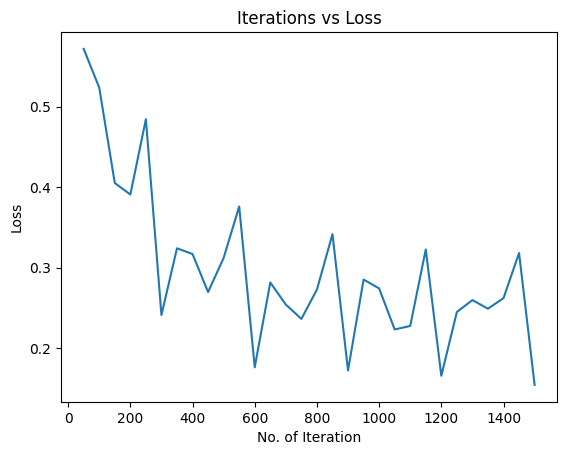

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

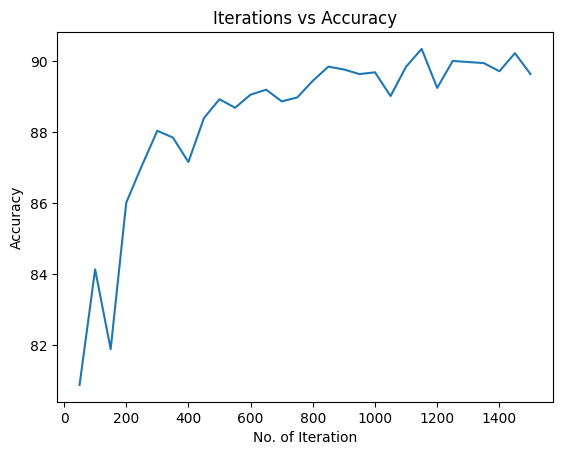

In [ ]:
import matplotlib.pyplot as plt
import torch

# assume iteration_list and accuracy_list are lists of tensors
iteration_list_cpu = [it.cpu().numpy() if isinstance(it, torch.Tensor) and it.is_cuda else it for it in iteration_list]
accuracy_list_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) and acc.is_cuda else acc for acc in accuracy_list]

plt.plot(iteration_list_cpu, accuracy_list_cpu)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()


### Looking the Accuracy in each class of FashionMNIST dataset

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of T-shirt/Top: 94.91%
Accuracy of Trouser: 98.16%
Accuracy of Pullover: 80.35%
Accuracy of Dress: 90.08%
Accuracy of Coat: 85.51%
Accuracy of Sandal: 90.53%
Accuracy of Shirt: 62.89%
Accuracy of Sneaker: 97.96%
Accuracy of Bag: 98.78%
Accuracy of Ankle Boot: 96.95%


### Printing the Confusion Matrix 

In [ ]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [ ]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     30000
           1       0.99      0.97      0.98     30000
           2       0.84      0.82      0.83     30000
           3       0.88      0.89      0.88     30000
           4       0.80      0.85      0.82     30000
           5       0.98      0.95      0.96     30000
           6       0.68      0.68      0.68     30000
           7       0.92      0.94      0.93     30000
           8       0.97      0.98      0.97     30000
           9       0.95      0.95      0.95     30000

    accuracy                           0.88    300000
   macro avg       0.88      0.88      0.88    300000
weighted avg       0.88      0.88      0.88    300000




### This is my implementation of deep learning in FashionMNIST dataset using Pytorch. I've achieved 93% test accuracy. Change those layer architecture or parameters to make it better. 
***I hope you like it. Give your feedback. It helps me to a lot. Thank you. :)***